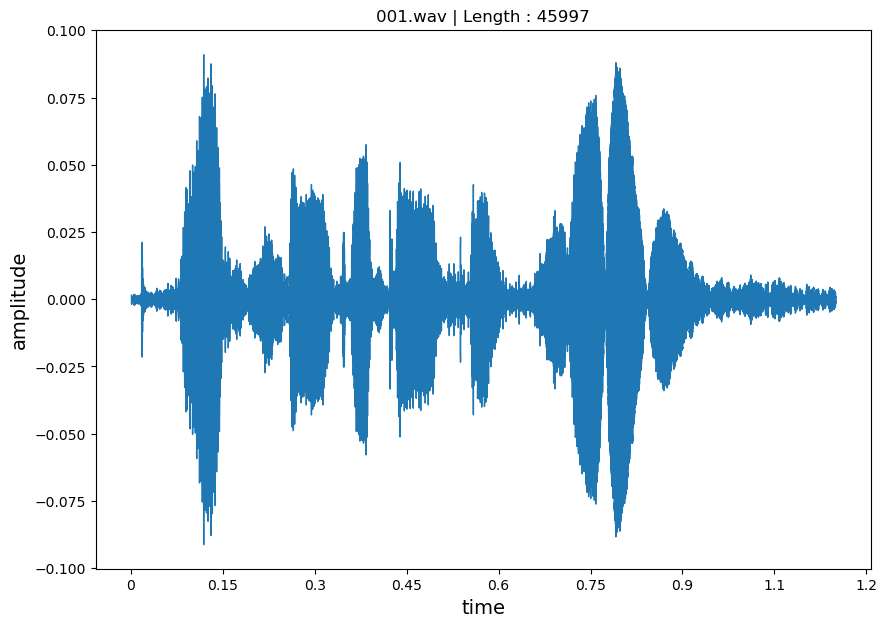

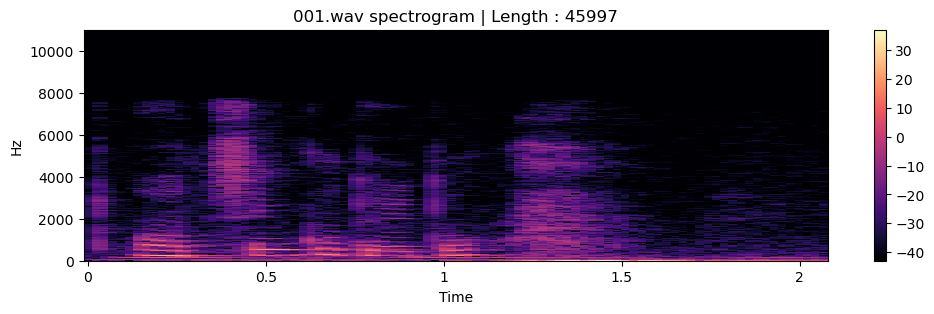

In [1]:
import numpy as np
import pandas as pd
import random as rn
import os

from scipy.io import wavfile
import librosa

import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# reproducibility

def all_seed(seed_num):
    np.random.seed(seed_num)
    rn.seed(seed_num)
    os.environ['PYTHONHASHSEED']=str(seed_num)
    # tf.random.set_seed(seed_num)

seed_num = 42
all_seed(seed_num)

a_filename = './wav/Sess01_script01_User001F_001.wav'
samples, sample_rate = librosa.load(a_filename)

plt.figure(figsize=(10, 7))

# plt.plot(np.linspace(0, sample_rate/len(samples), len(samples)), samples)
librosa.display.waveshow(samples, sr=40000)

plt.xlabel('time', fontsize = 14)
plt.ylabel('amplitude', fontsize = 14)
plt.title('001.wav | Length : ' + str(len(samples)))

plt.show()

samples, sample_rate = librosa.load(a_filename)
X = librosa.stft(samples)  # data -> short term FT
Xdb = librosa.amplitude_to_db(abs(X))

plt.figure(figsize=(12, 3))
plt.title('001.wav spectrogram | Length : ' + str(len(samples)))
librosa.display.specshow(Xdb, sr = sample_rate, x_axis='time', y_axis='hz')   
plt.colorbar()
plt.show()

In [2]:

from sklearn.preprocessing import MinMaxScaler
def extract_features(sample):
    
    # MFCC
    mfcc =librosa.feature.mfcc(y = sample, sr = sample_rate,n_mfcc=50)
    padded_mfcc = pad2d(mfcc, 600) #padding
    scaler = MinMaxScaler(feature_range=(0,1)) ## 각 칼럼 데이터 값을 0~1 범위로 변환

    scaler.fit(padded_mfcc) ## 각 칼럼 데이터마다 변환할 함수 생성

    scaled_padded_mfcc = scaler.transform(padded_mfcc) ## fit에서 만들어진 함수를 실제로 데이터에 적용

    result = np.array([scaled_padded_mfcc])
    return result
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))



(1, 50, 600)


In [3]:

np.random.seed(14) 
def noise(sample, rate):
    noise_amp = rate*np.random.uniform()*np.amax(sample)
    sample = sample + noise_amp*np.random.normal(size = sample.shape[0])
    return sample

# time stretching
def stretch(sample, rate):
    stretch_sample = librosa.effects.time_stretch(y=sample, rate=rate)
    return stretch_sample


# pitch 변환
def pitch(sample, pitch_factor, sampling_rate=22050):
    pitch_sample = librosa.effects.pitch_shift(y=sample, sr=sampling_rate, n_steps=pitch_factor)
    return pitch_sample


def get_features(path,num):

    sample, sample_rate = librosa.load(path)
    
    # without augmentation
    res1 = extract_features(sample)
    result = np.array(res1)
    
    for i in range(num//2):
        # sample with noise
        rate = np.random.uniform(0,0.2)
        noise_sample = noise(sample,rate)
        res2 = extract_features(noise_sample)
        result = np.vstack((result, res2)) 
    
    for i in range(num//2):
        # sample with stretching and pitching
        rate = np.random.uniform(0.7, 0.9)
        pitch_rate = np.random.uniform(0.7,0.9)
        str_sample = stretch(sample,rate)
        sample_stretch_pitch = pitch(str_sample,pitch_rate)
        res3 = extract_features(sample_stretch_pitch)
        result = np.vstack((result, res3)) 

    return result

In [4]:
import pickle

with open("train.pkl","rb") as fr:
    data = pickle.load(fr)
data

,Segment ID,temp+eda,text_tokenize,mfcc_scaled,sentiment_x
4194,Sess14_script02_User027F_021,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[241, 48, 9517, 4224, 53, 0, 0, 0, 0, 0, 0, 0,...","[[0.25491718193484303, 0.5859757467640792, 0.5...",4
2937,Sess09_script05_User018M_012,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[15, 72, 297, 1081, 25, 1, 4, 1621, 158, 5410,...","[[0.0, 0.38083732175090135, 0.8132520131083472...",0
81,Sess01_script02_User002M_021,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[75, 17, 43, 27, 209, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.39622842525417723, 1.0, 0.7046509808430651...",0
4524,Sess15_script02_User029M_030,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[105, 11, 157, 341, 90, 532, 2, 20, 2, 827, 17...","[[0.004803048548005395, 0.4873190168037505, 0....",0
10867,Sess35_script06_User069F_009,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[7, 68, 465, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.0, 0.46454147405152596, 0.5211101156252789...",0
...,...,...,...,...,...
456,Sess02_script04_User003F_013,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[218, 10, 3034, 125, 414, 0, 0, 0, 0, 0, 0, 0,...","[[0.33749878399108435, 0.9435183891680847, 0.6...",0
7176,Sess25_script01_User050F_018,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[14, 25, 1014, 28, 137, 11641, 2146, 25, 31, 4...","[[0.30946454832617043, 0.7226341044636214, 0.4...",0
709,Sess03_script03_User005M_016,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[42, 44, 89, 17, 89, 17, 40, 4891, 0, 0, 0, 0,...","[[0.0, 0.32382109728497616, 0.7688038963671658...",0
9525,Sess32_script03_User064F_006,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[2471, 201, 3253, 37, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.6906530605492214, 0.5176194922498784, 0.86...",0


In [6]:
data.columns

Index(['Segment ID', 'sentiment_x', 'Temp', 'EDA', 'temp+eda', 'text_tokenize',
       'mfcc_scaled', 'session', 'sess_num'],
      dtype='object')

In [5]:
#from sklearn.model_selection import train_test_split
#x_train, x_valid, y_train, y_valid = train_test_split(train[['Segment ID','temp+eda','text_tokenize','mfcc_scaled']], data['sentiment_x'], test_size=0.2, shuffle=True, random_state=4)
x_train = data[['Segment ID','temp+eda','text_tokenize','mfcc_scaled']]
y_train = data['sentiment_x']

In [6]:
data['sentiment_x'].value_counts()

0    7393
1     934
2     154
3     142
4     123
5      79
6      35
Name: sentiment_x, dtype: int64

In [19]:
len(data[data['sentiment_x']==0]),len(data[data['sentiment_x']==1]),len(data[data['sentiment_x']==2]),len(data[data['sentiment_x']==3]),len(data[data['sentiment_x']==4]),len(data[data['sentiment_x']==5]),len(data[data['sentiment_x']==6])

(7393, 934, 154, 142, 123, 79, 35)

In [23]:
#yes0
#no0
tmp = pd.concat([x_train,y_train], axis=1)
yes0 =tmp[tmp['sentiment_x']==0]
yes1 =tmp[tmp['sentiment_x']==1]
yes2 =tmp[tmp['sentiment_x']==2]
yes3 =tmp[tmp['sentiment_x']==3]
yes4 =tmp[tmp['sentiment_x']==4]
yes5 =tmp[tmp['sentiment_x']==5]
yes6 =tmp[tmp['sentiment_x']==6]


In [26]:
yes0 # augmentation X

,Segment ID,temp+eda,text_tokenize,mfcc_scaled,sentiment_x
2937,Sess09_script05_User018M_012,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[15, 72, 297, 1081, 25, 1, 4, 1621, 158, 5410,...","[[0.0, 0.38083732175090135, 0.8132520131083472...",0
81,Sess01_script02_User002M_021,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[75, 17, 43, 27, 209, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.39622842525417723, 1.0, 0.7046509808430651...",0
4524,Sess15_script02_User029M_030,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[105, 11, 157, 341, 90, 532, 2, 20, 2, 827, 17...","[[0.004803048548005395, 0.4873190168037505, 0....",0
10867,Sess35_script06_User069F_009,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[7, 68, 465, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.0, 0.46454147405152596, 0.5211101156252789...",0
10865,Sess35_script06_User070F_018,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[84, 199, 1964, 87, 6403, 394, 10, 1152, 245, ...","[[0.0, 0.35960252774523216, 0.7115982578944579...",0
...,...,...,...,...,...
456,Sess02_script04_User003F_013,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[218, 10, 3034, 125, 414, 0, 0, 0, 0, 0, 0, 0,...","[[0.33749878399108435, 0.9435183891680847, 0.6...",0
7176,Sess25_script01_User050F_018,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[14, 25, 1014, 28, 137, 11641, 2146, 25, 31, 4...","[[0.30946454832617043, 0.7226341044636214, 0.4...",0
709,Sess03_script03_User005M_016,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[42, 44, 89, 17, 89, 17, 40, 4891, 0, 0, 0, 0,...","[[0.0, 0.32382109728497616, 0.7688038963671658...",0
9525,Sess32_script03_User064F_006,"[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....","[2471, 201, 3253, 37, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.6906530605492214, 0.5176194922498784, 0.86...",0


In [24]:
y_train

4194     4
2937     0
81       0
4524     0
10867    0
        ..
456      0
7176     0
709      0
9525     0
1146     0
Name: sentiment_x, Length: 8860, dtype: int64

# yes1

In [27]:
from tqdm import tqdm
labels = yes1['sentiment_x']
x, y = [], []
file_name = ['./wav/'+f+'.wav' for f in yes1['Segment ID']]
NUM=6
for f, label in tqdm(zip(file_name, labels)):
    
    feature = get_features(f, NUM)
    #print(feature)
    for fe in feature:
        x.append(np.array(fe).transpose())

        y.append(label)

934it [14:10,  1.10it/s]


In [33]:
seg = [i for i in yes1['Segment ID'] for s in range(NUM+1)]
text = [i for i in yes1['text_tokenize'] for s in range(NUM+1)]
bio = [i for i in yes1['temp+eda'] for s in range(NUM+1)]

In [37]:

yes1df={'Segment ID': seg,'mfcc_scaled':x,'text_tokenize':text, 'temp+eda':bio,'sentiment_x':y}
yes1df = pd.DataFrame(yes1df)

In [29]:
x[0].shape

(600, 50)

In [38]:
yes1df

,Segment ID,mfcc_scaled,text_tokenize,temp+eda,sentiment_x
0,Sess10_script03_User020M_032,"[[0.0, 1.0, 0.8637900011655777, 0.876280838755...","[259, 392, 22, 340, 3308, 129, 57, 463, 340, 7...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",1
1,Sess10_script03_User020M_032,"[[0.0, 0.9320754049205668, 0.937099089634682, ...","[259, 392, 22, 340, 3308, 129, 57, 463, 340, 7...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",1
2,Sess10_script03_User020M_032,"[[0.0, 1.0, 0.9985543304972138, 0.981108102737...","[259, 392, 22, 340, 3308, 129, 57, 463, 340, 7...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",1
3,Sess10_script03_User020M_032,"[[0.0, 0.9707039064821303, 0.9712074009171563,...","[259, 392, 22, 340, 3308, 129, 57, 463, 340, 7...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",1
4,Sess10_script03_User020M_032,"[[0.0, 1.0, 0.8474357229661598, 0.877489726466...","[259, 392, 22, 340, 3308, 129, 57, 463, 340, 7...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",1
...,...,...,...,...,...
6533,Sess14_script01_User027F_013,"[[0.0, 1.0, 0.9023714716497058, 0.879960655407...","[1629, 1366, 2773, 43, 4, 106, 0, 0, 0, 0, 0, ...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",1
6534,Sess14_script01_User027F_013,"[[0.0, 1.0, 0.9722153107499117, 0.937284084561...","[1629, 1366, 2773, 43, 4, 106, 0, 0, 0, 0, 0, ...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",1
6535,Sess14_script01_User027F_013,"[[0.0, 1.0, 0.846895740817762, 0.8597909277973...","[1629, 1366, 2773, 43, 4, 106, 0, 0, 0, 0, 0, ...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",1
6536,Sess14_script01_User027F_013,"[[0.0, 1.0, 0.8455026233735855, 0.859607921095...","[1629, 1366, 2773, 43, 4, 106, 0, 0, 0, 0, 0, ...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",1


In [39]:
with open('augmentedyes1.pkl','wb') as fr:
    pickle.dump(yes1df, fr, pickle.HIGHEST_PROTOCOL)

# yes2

In [41]:
from tqdm import tqdm
labels = yes2['sentiment_x']
x, y = [], []
file_name = ['./wav/'+f+'.wav' for f in yes2['Segment ID']]
NUM=44
for f, label in tqdm(zip(file_name, labels)):
    
    feature = get_features(f, NUM)
    #print(feature)
    for fe in feature:
        x.append(np.array(fe).transpose())

        y.append(label)
seg = [i for i in yes2['Segment ID'] for s in range(NUM+1)]
text = [i for i in yes2['text_tokenize'] for s in range(NUM+1)]
bio = [i for i in yes2['temp+eda'] for s in range(NUM+1)]


yes2df={'Segment ID': seg,'mfcc_scaled':x,'text_tokenize':text, 'temp+eda':bio,'sentiment_x':y}
yes2df = pd.DataFrame(yes2df)

yes2df

154it [19:51,  7.74s/it]


,Segment ID,mfcc_scaled,text_tokenize,temp+eda,sentiment_x
0,Sess03_script04_User005M_008,"[[0.0, 0.9999999999999999, 0.9941890285497414,...","[34, 72, 58, 270, 6, 18, 3079, 23, 0, 0, 0, 0,...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",2
1,Sess03_script04_User005M_008,"[[0.0, 0.9388639827437543, 0.955683923491143, ...","[34, 72, 58, 270, 6, 18, 3079, 23, 0, 0, 0, 0,...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",2
2,Sess03_script04_User005M_008,"[[0.0, 0.8077108061429447, 0.9003661896846906,...","[34, 72, 58, 270, 6, 18, 3079, 23, 0, 0, 0, 0,...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",2
3,Sess03_script04_User005M_008,"[[0.0, 0.8211859799105545, 0.9010702490168991,...","[34, 72, 58, 270, 6, 18, 3079, 23, 0, 0, 0, 0,...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",2
4,Sess03_script04_User005M_008,"[[0.0, 0.928069625980279, 0.9590921300377185, ...","[34, 72, 58, 270, 6, 18, 3079, 23, 0, 0, 0, 0,...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",2
...,...,...,...,...,...
6925,Sess16_script06_User031M_022,"[[0.0, 1.0, 0.8552613719635881, 0.882517111771...","[15, 25, 3396, 1124, 9, 10005, 23, 8, 129, 8, ...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",2
6926,Sess16_script06_User031M_022,"[[0.0, 1.0, 0.855351609897419, 0.8840262973113...","[15, 25, 3396, 1124, 9, 10005, 23, 8, 129, 8, ...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",2
6927,Sess16_script06_User031M_022,"[[0.0, 1.0, 0.8547205449464095, 0.884194817138...","[15, 25, 3396, 1124, 9, 10005, 23, 8, 129, 8, ...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",2
6928,Sess16_script06_User031M_022,"[[0.0, 1.0, 0.8552177581769145, 0.884549524497...","[15, 25, 3396, 1124, 9, 10005, 23, 8, 129, 8, ...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",2


In [42]:
with open('augmentedyes2.pkl','wb') as fr:
    pickle.dump(yes2df, fr, pickle.HIGHEST_PROTOCOL)

# yes3

In [50]:
print(len(x), len(y), len(seg), len(text), len(bio))
#yes5df={'Segment ID': seg,'mfcc_scaled':x,'text_tokenize':text, 'temp+eda':bio,'sentiment_x':y}
len(yes3)*49

6958 6958 7100 7100 7100


6958

In [43]:
from tqdm import tqdm
labels = yes3['sentiment_x']
x, y = [], []
file_name = ['./wav/'+f+'.wav' for f in yes3['Segment ID']]
NUM=49
for f, label in tqdm(zip(file_name, labels)):
    
    feature = get_features(f, NUM)
    #print(feature)
    for fe in feature:
        x.append(np.array(fe).transpose())
        y.append(label)


142it [11:43,  4.95s/it]


ValueError: All arrays must be of the same length

In [51]:
seg = [i for i in yes3['Segment ID'] for s in range(NUM)]
text = [i for i in yes3['text_tokenize'] for s in range(NUM)]
bio = [i for i in yes3['temp+eda'] for s in range(NUM)]


yes3df={'Segment ID': seg,'mfcc_scaled':x,'text_tokenize':text, 'temp+eda':bio,'sentiment_x':y}
yes3df = pd.DataFrame(yes3df)

yes3df

,Segment ID,mfcc_scaled,text_tokenize,temp+eda,sentiment_x
0,Sess16_script03_User031M_043,"[[0.0, 1.0, 0.9121885360093822, 0.878451730675...","[232, 5146, 1817, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",3
1,Sess16_script03_User031M_043,"[[0.0, 0.9483531531606741, 0.9753146612257025,...","[232, 5146, 1817, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",3
2,Sess16_script03_User031M_043,"[[0.0, 0.9599427275340807, 0.9890042504292572,...","[232, 5146, 1817, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",3
3,Sess16_script03_User031M_043,"[[0.0, 0.9013080273001637, 0.9323683426548238,...","[232, 5146, 1817, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",3
4,Sess16_script03_User031M_043,"[[0.0, 0.9920232325397643, 0.9633572952559617,...","[232, 5146, 1817, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",3
...,...,...,...,...,...
6953,Sess29_script03_User058F_007,"[[0.0, 1.0, 0.690348744392395, 0.7212205529212...","[8, 487, 517, 22, 10, 3, 347, 91, 264, 362, 18...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",3
6954,Sess29_script03_User058F_007,"[[0.0, 1.0, 0.6902280449867249, 0.720862805843...","[8, 487, 517, 22, 10, 3, 347, 91, 264, 362, 18...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",3
6955,Sess29_script03_User058F_007,"[[0.0, 1.0, 0.690311849117279, 0.7209791541099...","[8, 487, 517, 22, 10, 3, 347, 91, 264, 362, 18...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",3
6956,Sess29_script03_User058F_007,"[[0.0, 1.0, 0.6906399130821228, 0.721310555934...","[8, 487, 517, 22, 10, 3, 347, 91, 264, 362, 18...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",3


In [52]:
with open('augmentedyes3.pkl','wb') as fr:
    pickle.dump(yes3df, fr, pickle.HIGHEST_PROTOCOL)

# yes4

In [53]:
from tqdm import tqdm
labels = yes4['sentiment_x']
x, y = [], []
file_name = ['./wav/'+f+'.wav' for f in yes4['Segment ID']]
NUM=57
for f, label in tqdm(zip(file_name, labels)):
    
    feature = get_features(f, NUM)
    #print(feature)
    for fe in feature:
        x.append(np.array(fe).transpose())

        y.append(label)


123it [19:41,  9.61s/it]


ValueError: All arrays must be of the same length

In [54]:
seg = [i for i in yes4['Segment ID'] for s in range(NUM)]
text = [i for i in yes4['text_tokenize'] for s in range(NUM)]
bio = [i for i in yes4['temp+eda'] for s in range(NUM)]


yes4df={'Segment ID': seg,'mfcc_scaled':x,'text_tokenize':text, 'temp+eda':bio,'sentiment_x':y}
yes4df = pd.DataFrame(yes4df)

yes4df

,Segment ID,mfcc_scaled,text_tokenize,temp+eda,sentiment_x
0,Sess14_script02_User027F_021,"[[0.0, 0.9999999999999999, 0.817147704223462, ...","[241, 48, 9517, 4224, 53, 0, 0, 0, 0, 0, 0, 0,...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",4
1,Sess14_script02_User027F_021,"[[0.0, 1.0, 0.9744229915542261, 0.946141754141...","[241, 48, 9517, 4224, 53, 0, 0, 0, 0, 0, 0, 0,...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",4
2,Sess14_script02_User027F_021,"[[0.0, 1.0, 0.9662816205622231, 0.934472124416...","[241, 48, 9517, 4224, 53, 0, 0, 0, 0, 0, 0, 0,...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",4
3,Sess14_script02_User027F_021,"[[0.0, 1.0, 0.8212451342343271, 0.834109042292...","[241, 48, 9517, 4224, 53, 0, 0, 0, 0, 0, 0, 0,...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",4
4,Sess14_script02_User027F_021,"[[0.0, 1.0, 0.9014086749921728, 0.879299845963...","[241, 48, 9517, 4224, 53, 0, 0, 0, 0, 0, 0, 0,...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",4
...,...,...,...,...,...
7006,Sess13_script05_User025F_033,"[[0.0, 1.0, 0.8512458116072616, 0.882711482695...","[44, 18, 30, 1918, 1918, 1453, 0, 0, 0, 0, 0, ...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",4
7007,Sess13_script05_User025F_033,"[[0.0, 1.0, 0.8522307947444836, 0.882726568845...","[44, 18, 30, 1918, 1918, 1453, 0, 0, 0, 0, 0, ...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",4
7008,Sess13_script05_User025F_033,"[[0.0, 1.0, 0.8498362696136494, 0.882909975506...","[44, 18, 30, 1918, 1918, 1453, 0, 0, 0, 0, 0, ...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",4
7009,Sess13_script05_User025F_033,"[[0.0, 1.0, 0.8503709266007918, 0.882666439902...","[44, 18, 30, 1918, 1918, 1453, 0, 0, 0, 0, 0, ...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",4


In [55]:
with open('augmentedyes4.pkl','wb') as fr:
    pickle.dump(yes4df, fr, pickle.HIGHEST_PROTOCOL)

# yes5

In [56]:
from tqdm import tqdm
labels = yes5['sentiment_x']
x, y = [], []
file_name = ['./wav/'+f+'.wav' for f in yes5['Segment ID']]
NUM=88
for f, label in tqdm(zip(file_name, labels)):
    
    feature = get_features(f, NUM)
    #print(feature)
    for fe in feature:
        x.append(np.array(fe).transpose())

        y.append(label)


79it [20:10, 15.32s/it]


ValueError: All arrays must be of the same length

In [58]:
seg = [i for i in yes5['Segment ID'] for s in range(NUM+1)]
text = [i for i in yes5['text_tokenize'] for s in range(NUM+1)]
bio = [i for i in yes5['temp+eda'] for s in range(NUM+1)]


yes5df={'Segment ID': seg,'mfcc_scaled':x,'text_tokenize':text, 'temp+eda':bio,'sentiment_x':y}
yes5df = pd.DataFrame(yes5df)

yes5df

,Segment ID,mfcc_scaled,text_tokenize,temp+eda,sentiment_x
0,Sess04_script04_User007M_031,"[[0.0, 1.0, 0.8305006932388344, 0.987547443878...","[21, 5022, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",5
1,Sess04_script04_User007M_031,"[[0.0, 0.9725347234243047, 0.9765945890246999,...","[21, 5022, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",5
2,Sess04_script04_User007M_031,"[[0.0, 0.9940750835307055, 0.9964518214068891,...","[21, 5022, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",5
3,Sess04_script04_User007M_031,"[[0.0, 0.9677985178502397, 0.9633831955087918,...","[21, 5022, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",5
4,Sess04_script04_User007M_031,"[[0.0, 0.9711772660730581, 0.988001875756158, ...","[21, 5022, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",5
...,...,...,...,...,...
7026,Sess10_script02_User019F_007,"[[0.0, 1.0000001192092896, 0.8574722409248352,...","[9, 384, 133, 149, 66, 3305, 27, 16, 230, 7, 2...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",5
7027,Sess10_script02_User019F_007,"[[0.0, 1.0, 0.8568810820579529, 0.866395056247...","[9, 384, 133, 149, 66, 3305, 27, 16, 230, 7, 2...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",5
7028,Sess10_script02_User019F_007,"[[0.0, 1.0, 0.8572065234184265, 0.865566611289...","[9, 384, 133, 149, 66, 3305, 27, 16, 230, 7, 2...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",5
7029,Sess10_script02_User019F_007,"[[0.0, 1.0, 0.8573614954948425, 0.866205155849...","[9, 384, 133, 149, 66, 3305, 27, 16, 230, 7, 2...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",5


In [59]:
with open('augmentedyes5.pkl','wb') as fr:
    pickle.dump(yes5df, fr, pickle.HIGHEST_PROTOCOL)

# yes6

In [60]:
from tqdm import tqdm
labels = yes6['sentiment_x']
x, y = [], []
file_name = ['./wav/'+f+'.wav' for f in yes6['Segment ID']]
NUM=202
for f, label in tqdm(zip(file_name, labels)):
    
    feature = get_features(f, NUM)
    #print(feature)
    for fe in feature:
        x.append(np.array(fe).transpose())

        y.append(label)
seg = [i for i in yes6['Segment ID'] for s in range(NUM+1)]
text = [i for i in yes6['text_tokenize'] for s in range(NUM+1)]
bio = [i for i in yes6['temp+eda'] for s in range(NUM+1)]


yes6df={'Segment ID': seg,'mfcc_scaled':x,'text_tokenize':text, 'temp+eda':bio,'sentiment_x':y}
yes6df = pd.DataFrame(yes6df)

yes6df

35it [21:05, 36.15s/it]


,Segment ID,mfcc_scaled,text_tokenize,temp+eda,sentiment_x
0,Sess13_script06_User026F_019,"[[0.0, 1.0, 0.8331247050700417, 0.848576583149...","[331, 29, 9462, 54, 4, 132, 70, 49, 3392, 9463...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",6
1,Sess13_script06_User026F_019,"[[0.0, 0.9539718677801134, 0.9779101026314533,...","[331, 29, 9462, 54, 4, 132, 70, 49, 3392, 9463...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",6
2,Sess13_script06_User026F_019,"[[0.0, 1.0, 0.9431895123378228, 0.933389839761...","[331, 29, 9462, 54, 4, 132, 70, 49, 3392, 9463...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",6
3,Sess13_script06_User026F_019,"[[0.0, 0.9514350072318388, 0.9917765852848993,...","[331, 29, 9462, 54, 4, 132, 70, 49, 3392, 9463...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",6
4,Sess13_script06_User026F_019,"[[0.0, 0.8989276765066728, 0.9556829367597306,...","[331, 29, 9462, 54, 4, 132, 70, 49, 3392, 9463...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",6
...,...,...,...,...,...
7100,Sess13_script06_User026F_018,"[[0.0, 1.0, 0.8347818434474994, 0.857236113457...","[987, 747, 21, 3392, 2441, 0, 0, 0, 0, 0, 0, 0...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",6
7101,Sess13_script06_User026F_018,"[[0.0, 0.9999999999999999, 0.8359336761314977,...","[987, 747, 21, 3392, 2441, 0, 0, 0, 0, 0, 0, 0...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",6
7102,Sess13_script06_User026F_018,"[[0.0, 1.0, 0.8343671902788821, 0.856397757347...","[987, 747, 21, 3392, 2441, 0, 0, 0, 0, 0, 0, 0...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",6
7103,Sess13_script06_User026F_018,"[[0.0, 1.0, 0.836014911151665, 0.8567119336117...","[987, 747, 21, 3392, 2441, 0, 0, 0, 0, 0, 0, 0...","[35.07, 35.07, 35.07, 35.07, 35.07, 35.07, 35....",6


In [61]:
with open('augmentedyes6.pkl','wb') as fr:
    pickle.dump(yes6df, fr, pickle.HIGHEST_PROTOCOL)

In [68]:
DF = pd.concat((yes0,yes1df,yes2df,yes3df,yes4df,yes5df,yes6df),axis=0)

In [69]:
DF['sentiment_x'].value_counts()

0    7393
6    7105
5    7031
4    7011
3    6958
2    6930
1    6538
Name: sentiment_x, dtype: int64

In [70]:
with open('augmented2.pkl','wb') as fr:
    pickle.dump(DF, fr, pickle.HIGHEST_PROTOCOL)

In [ ]:
DF = DF.sample(frac=1).reset_index(drop=True)

with open('augmentedhalf1.pkl','wb') as fr:
    pickle.dump(DF.iloc[:len(DF)//2], fr, pickle.HIGHEST_PROTOCOL)
with open('augmentedhalf2.pkl','wb') as fr:
    pickle.dump(DF.iloc[len(DF)//2:], fr, pickle.HIGHEST_PROTOCOL)
